# **Reporting Agent Demo**

The **Reporting Agent** is a tool that facilitates generating reports on events such as deviations in an industrial manufacturing process or in the context of traffic accidents.

The user is asked few questions (What, When, Where, Who, How, Why and Actions) that can be answered with key words or short sentences. An LLM is then used to generate a coherent, concise and well-structured text describing the event and including the provided information.


This demo notebook goes through the following steps:


1.   General setup (imports...)

2.   Load the Python environment from `requirements_colab.txt`

3.   Import the required app components

4.   Execute the demo. Although generation parameters are automatically proposed, the user can modify them and experiment their effect on the generated text.


**IMPORTANT NOTE #1**


*   The user is expected to clone the GitHub repo https://github.com/zBotta/reportingAgent/tree/dev (TODO: URL to update to main branch when work completed) and set it as working directory.
*   In the following, we assume the repository has been cloned to Google Drive in folder /GitHub/reportingAgent (adjust the path if required)



**IMPORTANT NOTE #2**


*   The LLM models are loaded from the Hugging Face. They require a token.
*   In the following, we assume the notebook is executed in a Google Colab runtime and that the user saved a valid Hugging Face token in the notebook secrets.

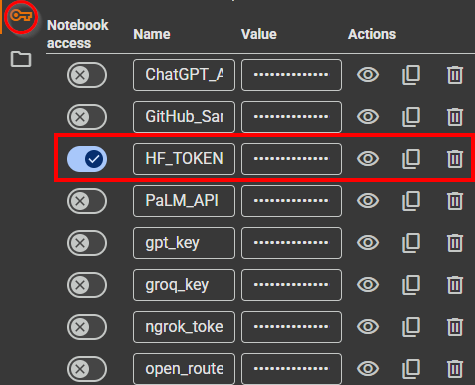

# **Imports and general setup**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# import sys
import os

# Managing secrets
from google.colab import userdata

# # Hugging Face login
# from huggingface_hub import login
# login(token=userdata.get('HF_TOKEN'))  # insert your Hugging Face token here


## Set cloned repo as working directory

In [ ]:
%cd /content/drive/MyDrive/GitHub/reportingAgent

# Check working dir
print(f"The current working directory is '{os.getcwd()}'")

# **Python Environment Setup**

**Note**: On Google Colab, restarting the session after completing the requirements installation may be required!

To manually restart a session use menu `Runtime>Restart session`. DO NOT DISCONNECT OR DELETE THE RUNTIME.

After restarting the session, re-execute the cells above.

In [ ]:
!pip install -r requirements_colab.txt
!pip install --upgrade torch torchvision

# **Import App Components**

## Required Python libraries

In [ ]:
# Pytorch and device/dtype setup
import torch

# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch_dtype = torch.float32 if torch.cuda.is_available() else torch.float32

device, torch_dtype

In [ ]:
# Miscellaneous
import copy

In [ ]:
# Creating interactive objects
import ipywidgets as widgets
from IPython.display import display, clear_output

## App specific modules

In [ ]:
from app.mods.promptGenerator import *
from app.mods.modelLoader import *
from app.mods.reportGenerator import *
from app.mods.dataHandler import *
# from app.mods.metricsEvaluator import * # ImportError: cannot import name '_center' from 'numpy._core.umath' (/usr/local/lib/python3.11/dist-packages/numpy/_core/umath.py)
# from app.mods.testBench import *

# Functions

In [ ]:
# Model selection

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global selected_model
        selected_model = change['new']
        global model_id
        model_id = models[selected_model]['model_id']
        print(f"Selected model: {selected_model}")
        print(f"Selected model_id: {model_id}\n")


# Model loading

def on_button_clicked(b):
    global model_loader
    global model_outlines
    global tokenizer
    with output_area:
        clear_output()
        print(f"Loading model: {model_id}...")
        try:
            model_loader = ModelLoader(model_id=model_id, device=device, torch_dtype=torch_dtype)
            model_outlines, tokenizer = model_loader.load_model(hf_token=userdata.get('HF_TOKEN'))
            print("Model loaded successfully!")
        except Exception as e:
            print(f"Error loading model: {e}")


# Prompt creation

def on_prompt_method_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        selected_method = change['new']
        print(f"------ Selected prompt method: {selected_method} ------\n")
        global prompt
        prompt = prompt_generator.create_prompt(prompt_method=selected_method)
        print(prompt, '\n', '------\n\n')


# Update generation_params when slider values change
def update_generation_params(change):
    global generation_params
    if change['owner'] == temperature_slider:
        generation_params['temperature'] = change['new']
        print(f"Updated temperature: {generation_params['temperature']}")
    elif change['owner'] == top_p_slider:
        generation_params['top_p'] = change['new']
        print(f"Updated top_p: {generation_params['top_p']}")
    print(f"Updated generation_params: {generation_params}\n")


# Generate report
def on_generate_report_button_clicked(b):
    with output_area_report:
        clear_output()
        print("Generating report...")
        try:
            # Ensure report_generator and prompt are available from previous cells
            if 'report_generator' not in globals() or 'prompt' not in globals():
                 print("Error: Report generator or prompt not initialized. Please run the necessary cells above.")
                 return

            # Generate the report
            output, gen_args = report_generator.generate_report(prompt, **generation_params)
            print("Report generated successfully.")

            # Process the generated output
            data_handler = DataHandler()
            title, report = data_handler.get_title_and_report(output, output_structure=Report)

            print("\n--- Selected Model ---\n")
            print(f"Model: {selected_model}")
            print(f"Model ID: {model_id}")
            print("\n--------------\n")

            print("\n--- Generation Parameters ---\n")
            for k in generation_params:
                print(f"{k}: {generation_params[k]}")
            print("\n--------------\n")

            print("\n--- Generated Report ---\n")
            print(f"Title: {title}\n")
            print(f"Report: {report}")
            print("\n--------------\n")

        except Exception as e:
            print(f"An error occurred during report generation or processing: {e}")

# **Reporting Agent Demo**

## List of models and suggested generation parameters

The proposed models are:


1.   **SmolLM2-360M-specialized**: is a **specialized** version of HuggingFaceTB/SmolLM2-360M-Instruct that has been **specifically trained** to produce reports with the desired structure based on the key information provided by the user. It has a small number of parameters (360 million) making it a good choice to execute on CPU.
2.   **Qwen2.5-0.5B**: light weight (0.5 billion parameters) instruct version was found to be well suited for the reporting task. Can proberly run on CPU.
3.   **Llama-3.2-3B**: mdedium size model (3 billion parameters), instruct version, well suited for reporting. But preferable to run on GPU.



In [ ]:
models = {
    'SmolLM2-360M-specialized': {
        'model_id': 'zBotta/smollm2-accident-reporter-360m',
        'generation_params': {'temperature': 0.7,
                              'top_p': 0.6,
                              'top_k': 50,
                              'max_new_tokens': 300,
                              'do_sample': True,
                              'repetition_penalty': 1.0
                              }
                                 },
    'Qwen2.5-0.5B': {
        'model_id': 'Qwen/Qwen2.5-0.5B-Instruct',
        'generation_params': {'temperature': 1.0,
                              'top_p': 0.6,
                              'top_k': 50,
                              'max_new_tokens': 300,
                              'do_sample': True,
                              'repetition_penalty': 1.0
                              }
                },
    'Llama-3.2-3B':{
        'model_id': 'meta-llama/Llama-3.2-3B-Instruct',
        'generation_params': {'temperature': 1.0,
                              'top_p': 0.6,
                              'top_k': 50,
                              'max_new_tokens': 300,
                              'do_sample': True,
                              'repetition_penalty': 1.0
                              }
                    },
          }

## Choose a model

Execute the next cell and select a model from the dropdown menu.

In [ ]:
model_names = list(models.keys())
model_dropdown = widgets.Dropdown(
    options=model_names,
    description='Models:',
    disabled=False
)

display(model_dropdown)

model_dropdown.observe(on_change)

# Set initial selected_model and model_id
selected_model = model_dropdown.value
model_id = models[selected_model]['model_id']
print(f"Initial selected model: {selected_model}")
print(f"Initial model_id: {model_id}\n")

## Load selected model

Execute the next cell and click on "Load Model" to load the selected model.

Check that the loading is successful.

In [ ]:
model_loader = None
model_outlines = None
tokenizer = None

load_button = widgets.Button(description="Load Model")
output_area = widgets.Output()

display(load_button, output_area)

load_button.on_click(on_button_clicked)

## Input event information

Execute the next cell and enter the key information on the event to be reported.

For example, with the following key information:


*   **What**: air pressure drop detected during tablet compression in Batch T-1023
*   **When**: February 18, 2024, at 16:00 (discovery)
*   **Where**: Compression Room CR-4
*   **Who**: Ethan Rogers, Process Engineer – discovered; Maintenance Lead Sarah Bennett – addressed issue
*   **How**: air leak in pneumatic system caused pressure drop
*   **Why**: failed seal identified
*   **Contingency Actions**: production paused, repair performed, batch quality assessment initiated, deviation investigation started (Ref: DEV-2024-041)

The expected generated text should be comparable to:


*   **Event title**: Inadequate Air Pressure During Compression
*   **Report**: At 16:00 on February 18, 2024, Ethan Rogers detected air pressure drop in CR-4 affecting batch T-1023. Sarah Bennett led repair of faulty seal. Production was paused, and batch quality is under review. Deviation DEV-2024-041 is active.





In [ ]:
prompt_generator = PromptGenerator()

## Choose a prompt method

Execute the next cell and use the dropdown menu to select the prompting method.

Method A is the simplest. Method B adds guidance to focus on accuracy and coherence of the generated text. Method C and D add an example (respectively in the field of the pharma industry and in the field of traffic accidents)

We recommend using prompting method C or D to obtain better results.

In [ ]:
prompt_method_dropdown = widgets.Dropdown(
    options=['A', 'B', 'C', 'D'],
    description='Prompt method:',
    disabled=False,
)

display(prompt_method_dropdown)

prompt_method_dropdown.observe(on_prompt_method_change)

# Set initial prompt and display it
initial_method = prompt_method_dropdown.value
prompt = prompt_generator.create_prompt(prompt_method=initial_method)
print(f"------ Initial prompt method: {initial_method} ------")
print(prompt, '\n', '------\n\n')


## Generate the report

### Choose generation parameters

Execute the next cell and choose generation parameters

Initially, generation parameters are set to the optimal values for each model. The user can override the default *temperature* and *top_p*.



*   *temperature*: a positive float value. Closer to 0.0 means more deteministic output, higher values means more creative generation process.
*   *top_p*: a float between 0.0 and 1.0. Lower value restricts the set of vocabulary to pick the next generated token. 1.0 indicates to pick from the entire vocabulary.


In [ ]:
# Get initial generation parameters directly from models dictionary
generation_params = copy.deepcopy(models[selected_model]['generation_params'])
print(f"Initial generation parameters: {generation_params}")

# Create interactive widgets for temperature and top_p
temperature_slider = widgets.FloatSlider(
    value=generation_params['temperature'], # Set to initial value
    min=0.0,
    max=1.3,
    step=0.1,
    description='temperature:',
    continuous_update=False, # Update only on release
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

top_p_slider = widgets.FloatSlider(
    value=generation_params['top_p'], # Set to initial value
    min=0.1,
    max=1.0,
    step=0.1,
    description='top_p:',
    continuous_update=False, # Update only on release
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

# Display the widgets
display(temperature_slider, top_p_slider)

# Observe changes in slider values
temperature_slider.observe(update_generation_params, names='value')
top_p_slider.observe(update_generation_params, names='value')

# Instantiate ReportGenerator (this part remains the same)
report_generator = ReportGenerator(model=model_outlines, tokenizer=tokenizer, output_type=Report)


### Generate and display the result

Execute the next cell and click on "Generate Report".

In [ ]:
generate_report_button = widgets.Button(description="Generate Report")
output_area_report = widgets.Output()

display(generate_report_button, output_area_report)

generate_report_button.on_click(on_generate_report_button_clicked)